# Payer Mix Linear Regression

**Objective:** Develop a linear regression model to predict the payer mix of health centers.

**Data:** 2018-2023 Uniform Data System dataset (from the [HRSA website](data.HRSA.gov))

**Model Type:** Linear regression

**Tools/Libraries:** Pandas, Scikit-Learn, Matplotlib, Seaborn
<br><br>

## Summary

For this project, I will build a linear regression model for predicting payer mix at health centers, using the annual Uniform Data System dataset published by HRSA. I'll first prepare the data for the model and then run a simple linear regression to evaluate the baseline performance. Last, I will use lasso regression to fine tune the model and help select features that are most relevant to payer mix prediction.

This model could be utilized for both prediction or inference purposes. One could predict how changes to independent variables could shift payer mix at a given health center, improving financial and clinical forecasts. Additionally, if an organization is planning to establish a new health center, by inputting some assumptions about the expected demographics and clinical measures, a payer mix could be predicted (although this would require assumptions that may be quite difficult to determine). For inference purposes, the model could help existing health centers better understand which independent variables most siginifantly impact payer mix.

## Table of Contents
1. Dataset
2. Data Wrangling
      - Exploratory Data Analysis
      - Imputation
      - Correlation
      - Categorical Variables
3. Model Building
      - Baseline Models
      - Tuned Models
      - Evaluation
4. Conclusion

## Dataset
The Health Resources and Services Administration (HRSA) oversees the national health center program, which includes 1,496 health centers serving 32.5 million patients across the U.S. In overseeing this program, HRSA collects financial and clinical data from health centers via the annual Uniform Data System (UDS) report, much of which is publicly available.

**Note:** For this project, I am utilizing UDS data that I previously prepared for analysis in a SQL database. To see how the data was prepared, you can view my full SQL project [here](https://github.com/tyler-dardis/Health-Center-Data-ELT).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading data files into dataframe

First, I'll load the .csv files into separate Pandas dataframes and then merge them into one combined dataframe.

In [3]:
# Load csv files into dataframes
filepath = '/content/drive/My Drive/Colab Notebooks/Datasets/UDS/'
df_clinical = pd.read_csv(filepath + 'clinical_data_2018-2023.csv')
df_cost = pd.read_csv(filepath + 'cost_2018-2023.csv')
df_patient_age_race = pd.read_csv(filepath + 'patient_age_race_2018-2023.csv')
df_payer_mix_fpl = pd.read_csv(filepath + 'payer_mix_fpl_2018-2023.csv')
df_services = pd.read_csv(filepath + 'services_2018-2023.csv')

In [6]:
# Confirm each dataframe contains the same number of rows (should be 8,829)
print(df_clinical.shape[0])
print(df_cost.shape[0])
print(df_patient_age_race.shape[0])
print(df_payer_mix_fpl.shape[0])
print(df_services.shape[0])

8829
8829
8829
8829
8829


In [7]:
# Merge all the dataframes into one combined dataframe
df = pd.merge(df_clinical, df_cost, on=['hc_name', 'year', 'city', 'state', 'hc_type'])
df = pd.merge(df, df_patient_age_race, on=['hc_name', 'year', 'city', 'state', 'hc_type'])
df = pd.merge(df, df_payer_mix_fpl, on=['hc_name', 'year', 'city', 'state', 'hc_type'])
df = pd.merge(df, df_services, on=['hc_name', 'year', 'city', 'state', 'hc_type'])

Because this dataset spans six years, I'm deciding to only include the most recent year (2023) in this project. This ensures that I'm using the most current data available and prevents data leakage, as health centers are reported in each year they were operating. If I used all years, it would be possible for a health center to be present in both the training and testing datasets, resulting in data leakage.

In [8]:
# Keep only 2023 data
df = df[df['year'] == 2023]
df = df.reset_index(drop=True)

# Drop columns that won't be used for linear regression model
df = df.drop(['hc_name', 'city', 'year'], axis=1)

In [9]:
# Inspect df info to confirm the data loaded and merged as expected.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   state                          1496 non-null   object
 1   hypertension                   1496 non-null   object
 2   diabetes                       1496 non-null   object
 3   asthma                         1496 non-null   object
 4   hiv                            1496 non-null   object
 5   prenatal_patients              1496 non-null   object
 6   prenatal_patients_delivered    1496 non-null   object
 7   access_to_prenatal_care        1496 non-null   object
 8   low_birth_weight               1496 non-null   object
 9   cervical_cancer_screening      1496 non-null   object
 10  adolescent_weight_screening    1496 non-null   object
 11  adult_weight_screening         1496 non-null   object
 12  adult_tobacco_use_screening    1496 non-null   object
 13  col

## Data Wrangling

The .info() output above indicates that two aspects of the data need to be addressed:
1. Every column contains 1,496 non-null values (0 null values). I know that this is incorrect, so I need to inspect the data to find the cause of this.
2. Most of the columns were recognized as dtype 'object'. Almost all of these need to be changed to dtype 'float64'.

In [10]:
# To address the first issue, I'll look at first few rows of df
pd.set_option('display.max_columns', None)
df.head()

,state,hypertension,diabetes,asthma,hiv,prenatal_patients,prenatal_patients_delivered,access_to_prenatal_care,low_birth_weight,cervical_cancer_screening,adolescent_weight_screening,adult_weight_screening,adult_tobacco_use_screening,colorectal_cancer_screening,childhood_immunization,depression_screening,dental_sealants,asthma_treatment,statin_therapy_cardio_disease,heart_attack_stroke_treatment,bp_control,uncontrolled_diabetes,hiv_linkage_to_care,breast_cancer_screening,depression_remission,hiv_screening,hc_type,svc_grant_exp,total_cost,total_cost_per_patient,total_patients,children,adults_18to64,adults_over64,race_ethno_minority,hisp_lat_ethno,black,asian,native_amer_alaska,native_hawaii_pacific,more_than_one_race,another_language,children_count,adults_18to64_count,adults_over64_count,patients_at_below_200_fpl,patients_at_below_100_fpl,uninsured,medicaid,medicare,other_payer,uninsured_count,medicaid_count,medicare_count,other_payer_count,medical,dental,mental_health,substance_abuse,vision,enabling,medical_count,dental_count,mental_health_count,substance_abuse_count,vision_count,enabling_count
0,AR,0.433095,0.193644,0.0486599,\N,76,60,0.828947,\N,0.226144,0.484206,0.810046,0.787982,0.408775,0.0949721,0.447368,\N,\N,0.739161,0.83682,0.675529,0.271209,\N,0.474556,\N,0.0235849,FQHC,4607246,24876771,1344.25,18506,0.311088,0.536745,0.152167,0.108312,0.0579037,0.0157692,0.00204415,0.00443873,0.0224273,0.0143675,0.0344213,5757,9933,2816,0.826421,0.562208,0.134875,0.387496,0.190425,0.287204,2496,7171,3524,5315,0.983897,0,0.0256133,0,0,0.0494975,18208,0,474,0,0,916
1,IN,0.424212,0.253184,0.0384235,0.000672016,231,133,0.753247,\N,0.489732,0.423712,0.866877,0.908585,0.63721,0.138462,0.732691,\N,\N,0.717303,0.693236,0.734035,0.204874,0,0.740365,0.230548,0.262421,Look-Alike,\N,22683097,778.231,29147,0.134765,0.591073,0.274162,0.449708,0.24577,0.242003,0.00138883,0.00221345,0.000911419,0.00763856,0.0529729,3928,17228,7991,0.544243,0.0905546,0.0155419,0.273407,0.302261,0.40879,453,7969,8810,11915,0.867911,0,0.16259,0,0,0,25297,0,4739,0,0,0
2,CA,0.197,0.143731,0.0208748,\N,23,\N,0.869565,0,0.636015,\N,0.843054,0.945802,0.612205,\N,0.732899,\N,\N,0.897143,\N,0.639594,0.163121,\N,0.614719,\N,0.936147,Look-Alike,\N,1060613,1054.29,1006,0,0.900596,0.0994036,0.940707,0.254484,0.068314,0.774709,\N,\N,0.0334302,0.466203,0,906,100,0.98645,0.0487805,0.0347913,0.677932,0.0506958,0.236581,35,682,51,238,1,0.0159046,\N,\N,\N,\N,1006,16,\N,\N,\N,\N
3,KY,0.231095,0.164517,0.0362264,\N,\N,\N,\N,0,0.514368,0.739518,0.695253,0.939421,0.490291,\N,0.68591,\N,\N,0.771863,0.671756,0.660225,0.207729,0,0.702703,\N,0.240486,FQHC,602119,7817357,1876.02,4167,0.301176,0.561555,0.137269,0.0219171,0.00673077,0.00626506,\N,\N,0,0.00746988,\N,1255,2340,572,0.846698,0.349057,0.0223182,0.359731,0.167507,0.450444,93,1499,698,1877,0.953924,0,0.141589,0,0,0.0832733,3975,0,590,0,0,347
4,CA,0.193017,0.123519,0.0440234,0.00557258,\N,\N,\N,\N,0.508824,0.86031,0.735494,0.981567,0.228835,0,0.434852,0,\N,0.784444,0.955224,0.544369,0.361644,\N,0.749042,\N,0.434851,FQHC,1320104,4586363,1277.89,3589,0.14628,0.748119,0.1056,0.680732,0.446937,0.117347,0.0612245,\N,\N,0.0663265,0.319866,525,2685,379,0.943193,0.795303,0.0905545,0.731123,0.0919476,0.086375,325,2624,330,310,1,0.220953,0.0554472,\N,\N,0.339649,3589,793,199,\N,\N,1219


In [11]:
# I now see that the null values are represented as '\N' in df.
# I'll replace these with 'NaN', which Pandas recognizes as null.
df = df.replace('\\N', np.nan)

# To address the dtype issue, the following code will convert columns to float64 dtype, where appropriate
for col in df.columns:
    if col not in ['state', 'hc_type']:
        df[col] = df[col].astype('float64')

In [12]:
# View df info to confirm that the issues have been resolved
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1496 entries, 0 to 1495
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          1496 non-null   object 
 1   hypertension                   1494 non-null   float64
 2   diabetes                       1495 non-null   float64
 3   asthma                         1488 non-null   float64
 4   hiv                            844 non-null    float64
 5   prenatal_patients              1208 non-null   float64
 6   prenatal_patients_delivered    1063 non-null   float64
 7   access_to_prenatal_care        1060 non-null   float64
 8   low_birth_weight               642 non-null    float64
 9   cervical_cancer_screening      1491 non-null   float64
 10  adolescent_weight_screening    1432 non-null   float64
 11  adult_weight_screening         1496 non-null   float64
 12  adult_tobacco_use_screening    1495 non-null   f

The .info() output above shows me that the '\N' values were correctly set as 'NaN' values and the columns were converted to dtype 'float64' where necessary.

Some of the columns contain essentially the same information as others. For example, children are reported both as counts (total number of children) and as percentages (percent of total patients that are children). These percentages help normalize the data across all health centers, so I'll drop the columns with patient counts if percentages are also provided.

This will also reduce multicollinearity in the model, since these counts can be assumed to have a strong correlation with 'total_patients'.



In [13]:
# Drop count columns that have corresponding % columns.
df = df.drop(['children_count',
              'adults_18to64_count',
              'adults_over64_count',
              'uninsured_count',
              'medicaid_count',
              'medicare_count',
              'other_payer_count',
              'medical_count',
              'dental_count',
              'mental_health_count',
              'substance_abuse_count',
              'vision_count',
              'enabling_count'], axis=1)

In [14]:
# Similar to the % columns above, the 'total_cost' column can be dropped because the 'total_cost_per_patient' column contains essentially the same information but normalized.
df = df.drop(['total_cost'], axis=1)

# 'svc_grant_exp' can be handled similar to 'total_cost', however 'svc_grant_exp_per_patient' does not yet exist, so I'll first create it and drop the 'svc_grant_exp' column.
df['svc_grant_exp_per_patient'] = df['svc_grant_exp']/df['total_patients']
df = df.drop(['svc_grant_exp'], axis=1)

### Exploratory Data Analysis

To better understand the dataset and view the distribution of each column's values, I'll generate a statistical summary of the dataframe and histograms for all numeric columns.

In [15]:
# View statistical summary of all numeric columns
df.describe()

,hypertension,diabetes,asthma,hiv,prenatal_patients,prenatal_patients_delivered,access_to_prenatal_care,low_birth_weight,cervical_cancer_screening,adolescent_weight_screening,adult_weight_screening,adult_tobacco_use_screening,colorectal_cancer_screening,childhood_immunization,depression_screening,dental_sealants,asthma_treatment,statin_therapy_cardio_disease,heart_attack_stroke_treatment,bp_control,uncontrolled_diabetes,hiv_linkage_to_care,breast_cancer_screening,depression_remission,hiv_screening,total_cost_per_patient,total_patients,children,adults_18to64,adults_over64,race_ethno_minority,hisp_lat_ethno,black,asian,native_amer_alaska,native_hawaii_pacific,more_than_one_race,another_language,patients_at_below_200_fpl,patients_at_below_100_fpl,uninsured,medicaid,medicare,other_payer,medical,dental,mental_health,substance_abuse,vision,enabling,svc_grant_exp_per_patient
count,1494.000000,1495.000000,1488.000000,844.000000,1208.000000,1063.000000,1060.000000,642.000000,1491.000000,1432.000000,1496.000000,1495.000000,1487.000000,967.000000,1496.000000,797.000000,0.0,1493.000000,1400.000000,1492.000000,1480.000000,207.000000,1475.000000,889.000000,1490.000000,1496.00000,1496.000000,1496.000000,1496.000000,1496.000000,1496.000000,1474.000000,1438.000000,1320.000000,1217.000000,937.000000,1319.000000,1399.000000,1496.000000,1489.000000,1495.000000,1496.000000,1494.000000,1493.000000,1496.000000,1369.000000,1457.000000,1135.000000,1015.000000,1244.000000,1363.000000
mean,0.294716,0.166328,0.053393,0.017574,499.826987,301.160865,0.750185,0.064015,0.493529,0.661845,0.648608,0.827975,0.389568,0.285761,0.700565,0.576548,NaN,0.765162,0.755711,0.643061,0.292764,0.436809,0.492762,0.170764,0.428352,1665.89642,21724.088904,0.246032,0.618683,0.135286,0.581828,0.307186,0.231233,0.048583,0.034353,0.019559,0.034082,0.231561,0.876660,0.631707,0.190485,0.458630,0.126398,0.225213,0.832655,0.215501,0.108756,0.020274,0.034106,0.107728,294.800996
std,0.100269,0.053749,0.024677,0.049570,884.035136,486.260427,0.167080,0.075351,0.167367,0.242538,0.228074,0.152575,0.156026,0.199602,0.199578,0.259355,NaN,0.094276,0.117296,0.095537,0.092402,0.460393,0.157407,0.179209,0.238128,1504.15641,27360.319602,0.123773,0.115289,0.073656,0.314663,0.282312,0.255667,0.117984,0.109317,0.089893,0.064327,0.236485,0.124841,0.202734,0.160846,0.188877,0.080596,0.129660,0.161828,0.168074,0.121180,0.055067,0.068360,0.164390,489.539431
min,0.013574,0.023266,0.002436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018848,0.002721,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.201646,0.035897,0.000000,0.000000,0.000000,0.000000,153.42400,136.000000,0.000000,0.121554,0.000000,0.007758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028752,0.012793,0.000000,0.000000,0.000000,0.000000,0.071039,0.000000,0.000000,0.000000,0.000000,0.000000,8.047793
25%,0.226952,0.133676,0.036627,0.001280,39.000000,32.000000,0.657151,0.000000,0.385831,0.528217,0.473458,0.775543,0.283774,0.150556,0.586784,0.411311,NaN,0.723333,0.696530,0.582887,0.238527,0.000000,0.389993,0.051948,0.221448,1037.40500,6373.250000,0.161894,0.547311,0.082918,0.297111,0.061847,0.024213,0.006571,0.003836,0.001765,0.007456,0.037629,0.825680,0.492788,0.073660,0.313997,0.066397,0.131140,0.760592,0.087021,0.040916,0.000000,0.000000,0.008849,135.766694
50%,0.283841,0.164040,0.050131,0.003699,161.500000,113.000000,0.772277,0.071026,0.509127,0.719765,0.675058,0.872483,0.388167,0.277304,0.735439,0.589306,NaN,0.778775,0.767442,0.647059,0.282007,0.000000,0.504961,0.109705,0.432690,1332.48000,12951.000000,0.245001,0.601652,0.116706,0.658852,0.207218,0.124021,0.014232,0.007990,0.003989,0.016254,0.154471,0.918462,0.648784,0.148428,0.453334,0.108788,0.207434,0.878965,0.185064,0.074929,0.004236,0.000000,0.041979,208.334723
75%,0.356023,0.195755,0.065989,0.011476,581.000000,358.500000,0.869449,0.095482,0.617895,0.849954,0.852515,0.931634,0.496029,0.398462,0.854335,0.782609,NaN,0.824341,0.833699,0.70

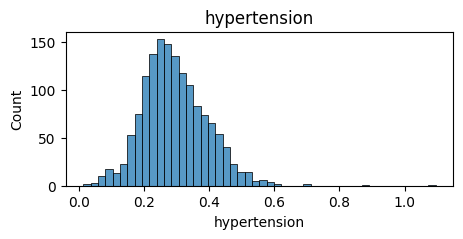

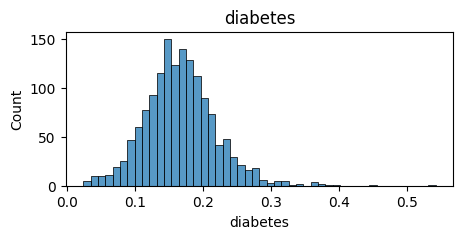

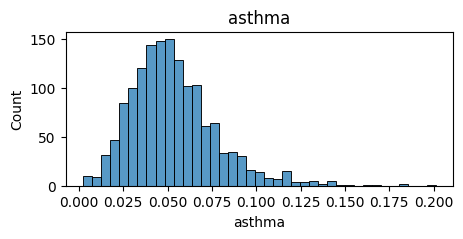

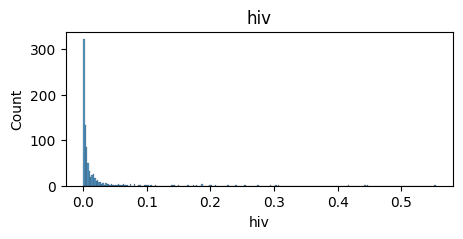

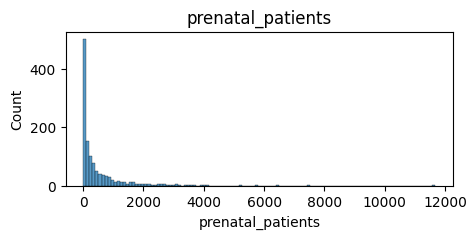

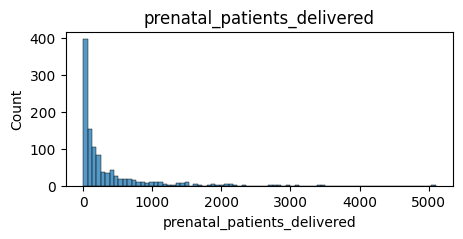

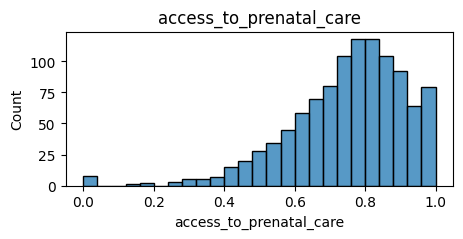

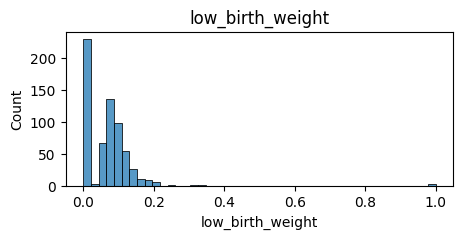

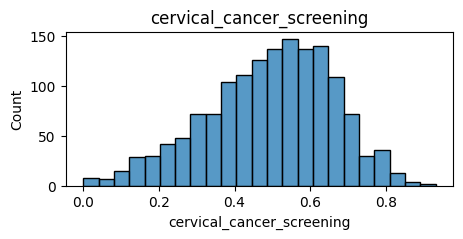

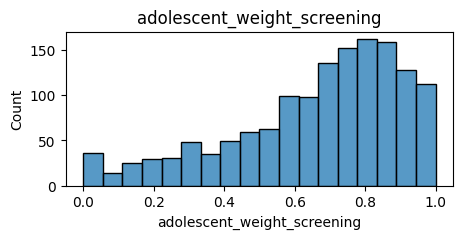

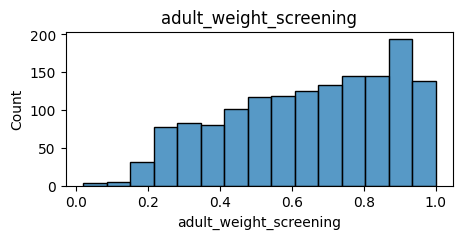

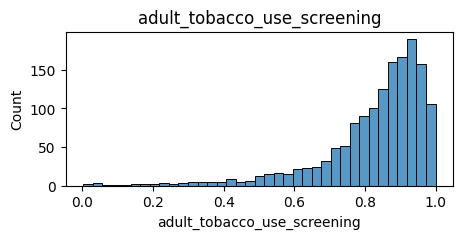

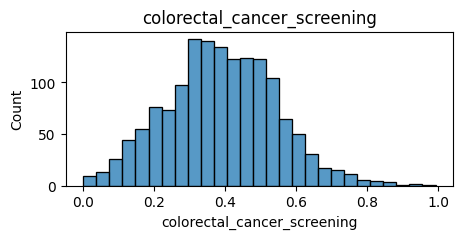

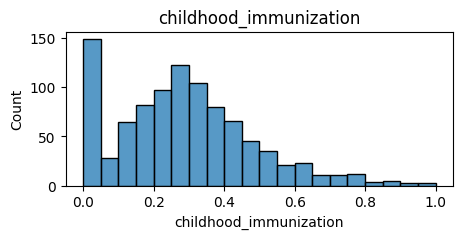

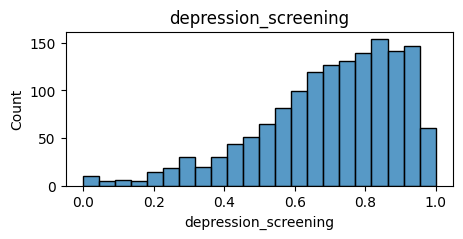

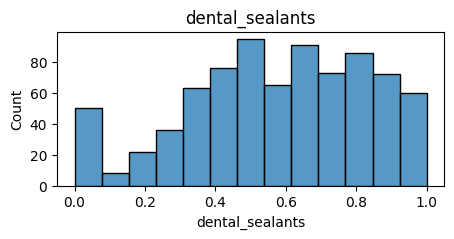

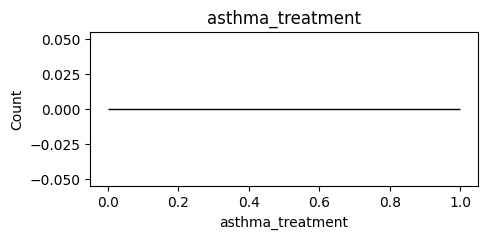

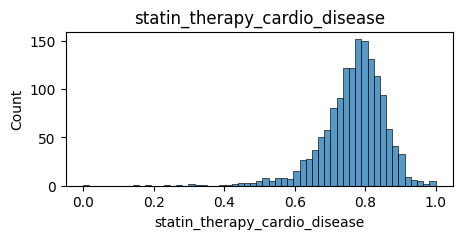

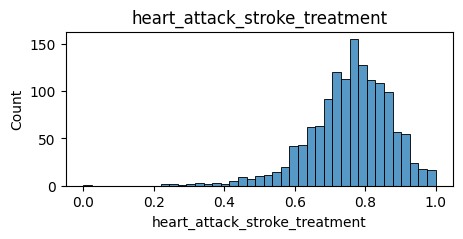

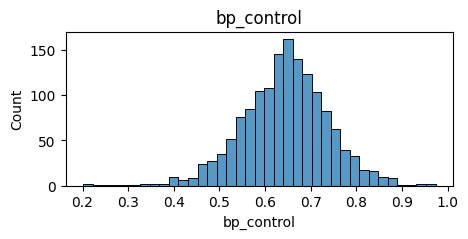

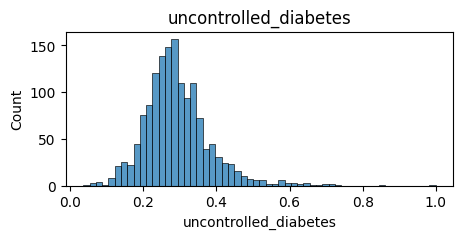

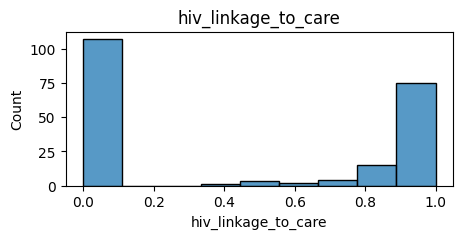

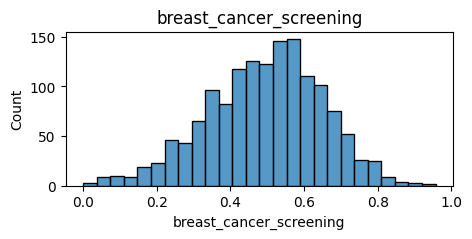

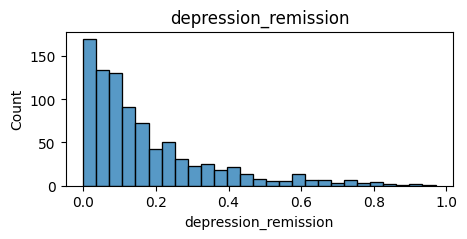

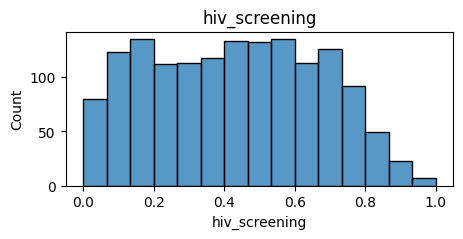

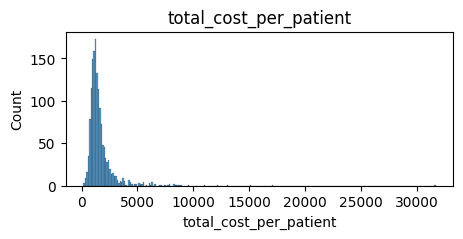

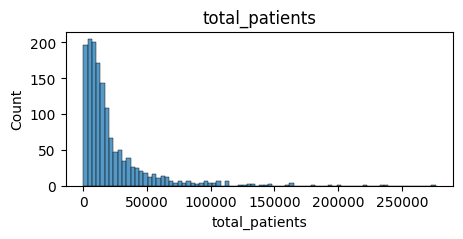

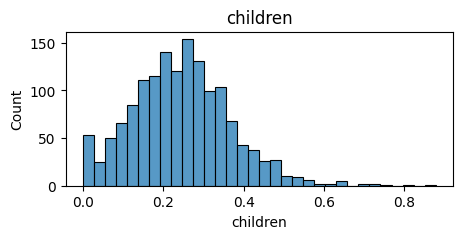

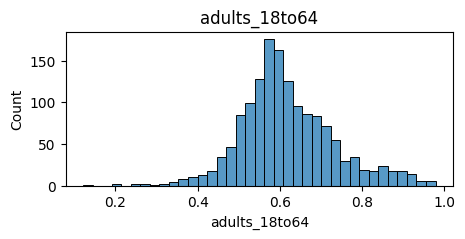

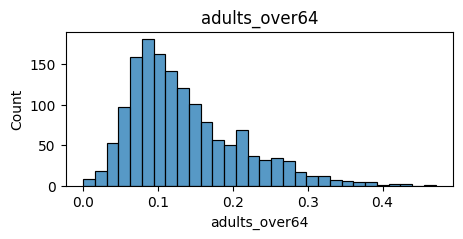

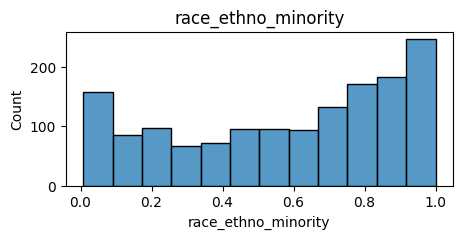

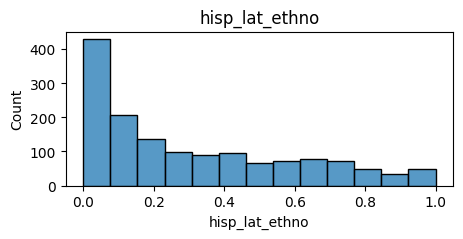

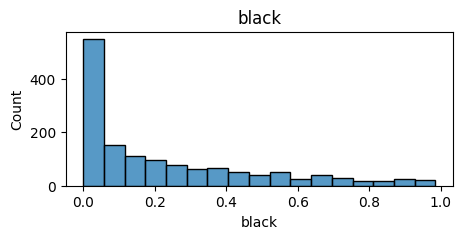

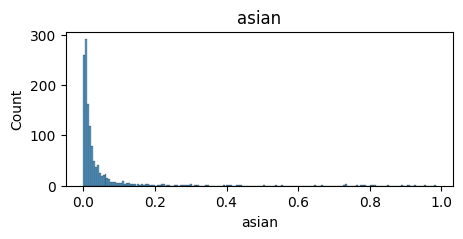

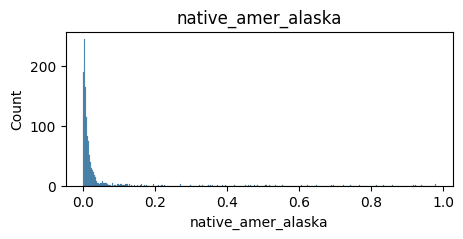

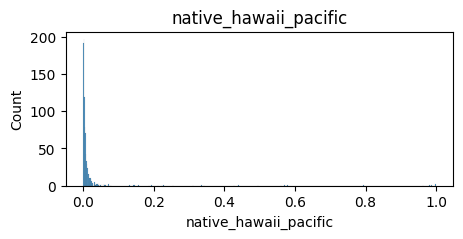

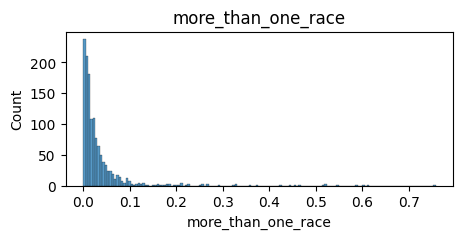

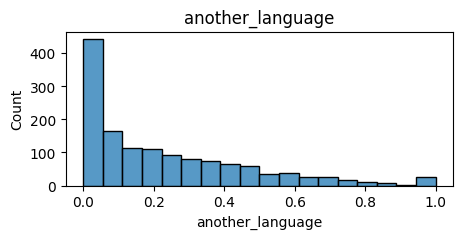

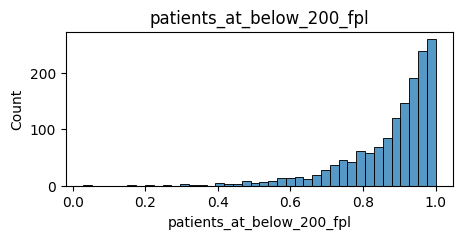

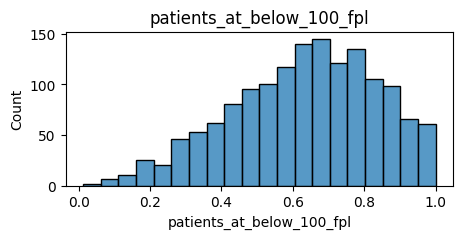

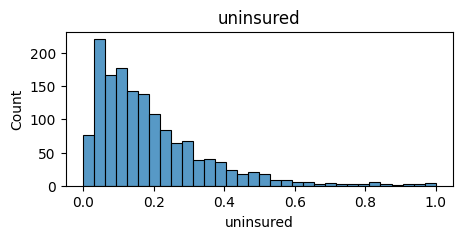

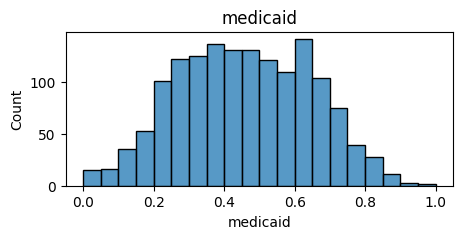

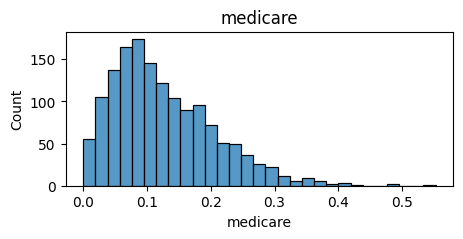

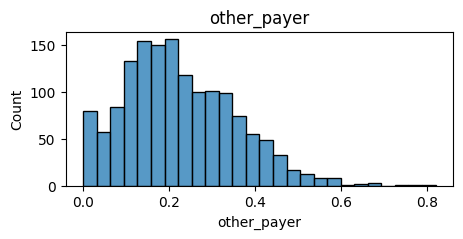

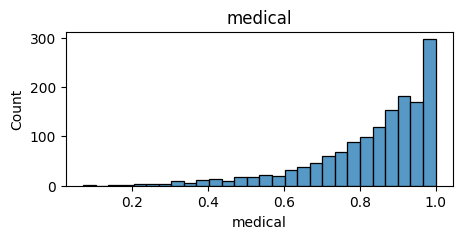

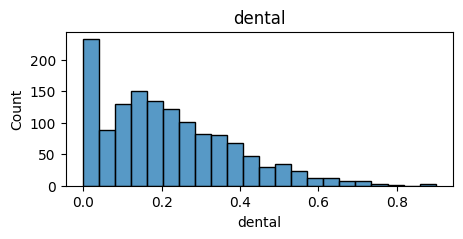

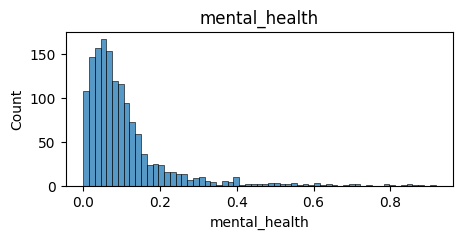

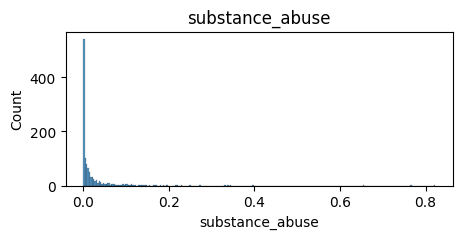

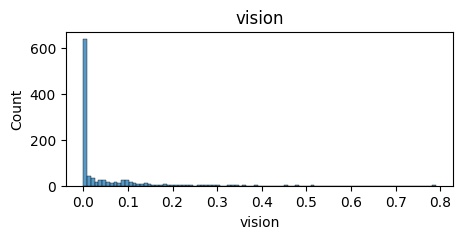

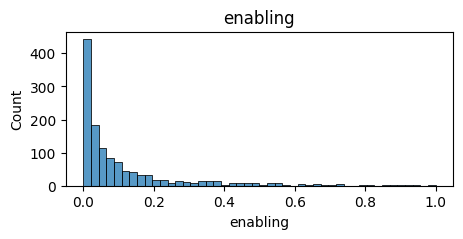

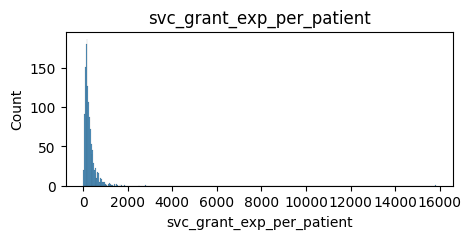

In [16]:
# Generate histograms for all numeric columns
for col in df.describe().columns:
  plt.figure(figsize=(5,2))
  sns.histplot(df[col])
  plt.title(col)
  plt.show()


As previously noted, the dataset contains null values. Most of these nulls can be replaced using imputation, but first I'll remove columns that contain over 50% null values, as these will likely not benefit my model.

In [17]:
# Determine percentage of null values in each column
(df.isnull().sum()/len(df)*100).sort_values()

,0
state,0.000000
medical,0.000000
medicaid,0.000000
patients_at_below_200_fpl,0.000000
race_ethno_minority,0.000000
adults_over64,0.000000
adults_18to64,0.000000
children,0.000000
total_patients,0.000000
total_cost_per_patient,0.000000


In [18]:
# Drop columns where over 50% of the data is null
df = df.drop(['low_birth_weight',
              'hiv_linkage_to_care',
              'asthma_treatment'], axis=1)

Before imputation, I'll replace null values in the 'svc_grant_exp_per_patient' column with 0. All health centers with null values in this column are Look-Alike type health centers. Since Look-Alikes do not receive service grants, it can be assumed that these nulls are actually 0 values.

I'll also convert the 'hc_type' column from a string to numeric (this is a binary categorical variable, and can be easily converted to numeric values).

In [19]:
# Replace null values in 'svc_grant_exp_per_patient' column with 0.
df['svc_grant_exp_per_patient'] = df['svc_grant_exp_per_patient'].fillna(0)

# Convert 'hc_type' to numerical values
df['hc_type'] = df['hc_type'].map({'FQHC': 1, 'Look-Alike': 0})

### Imputation

Because the histrograms above indicate that most of the columns do not have normal distributions, I've chosen to impute all remaining nulls with median values.

In [20]:
# Perform imputation using median values
col_to_impute = df.drop(columns=['state'])
imputer = SimpleImputer(strategy='median')
df[col_to_impute.columns] = imputer.fit_transform(col_to_impute)

In [21]:
# Confirm that all nulls have been addressed (output should return 0)
sum(df.isnull().sum())

0

### Correlation
To view the correlation between variables, I'll create a correlation heatmap. At this point, it can be seen that some variables are highly correlated with one another. To avoid multicollinearity in the model, I need to remove some of these columns.

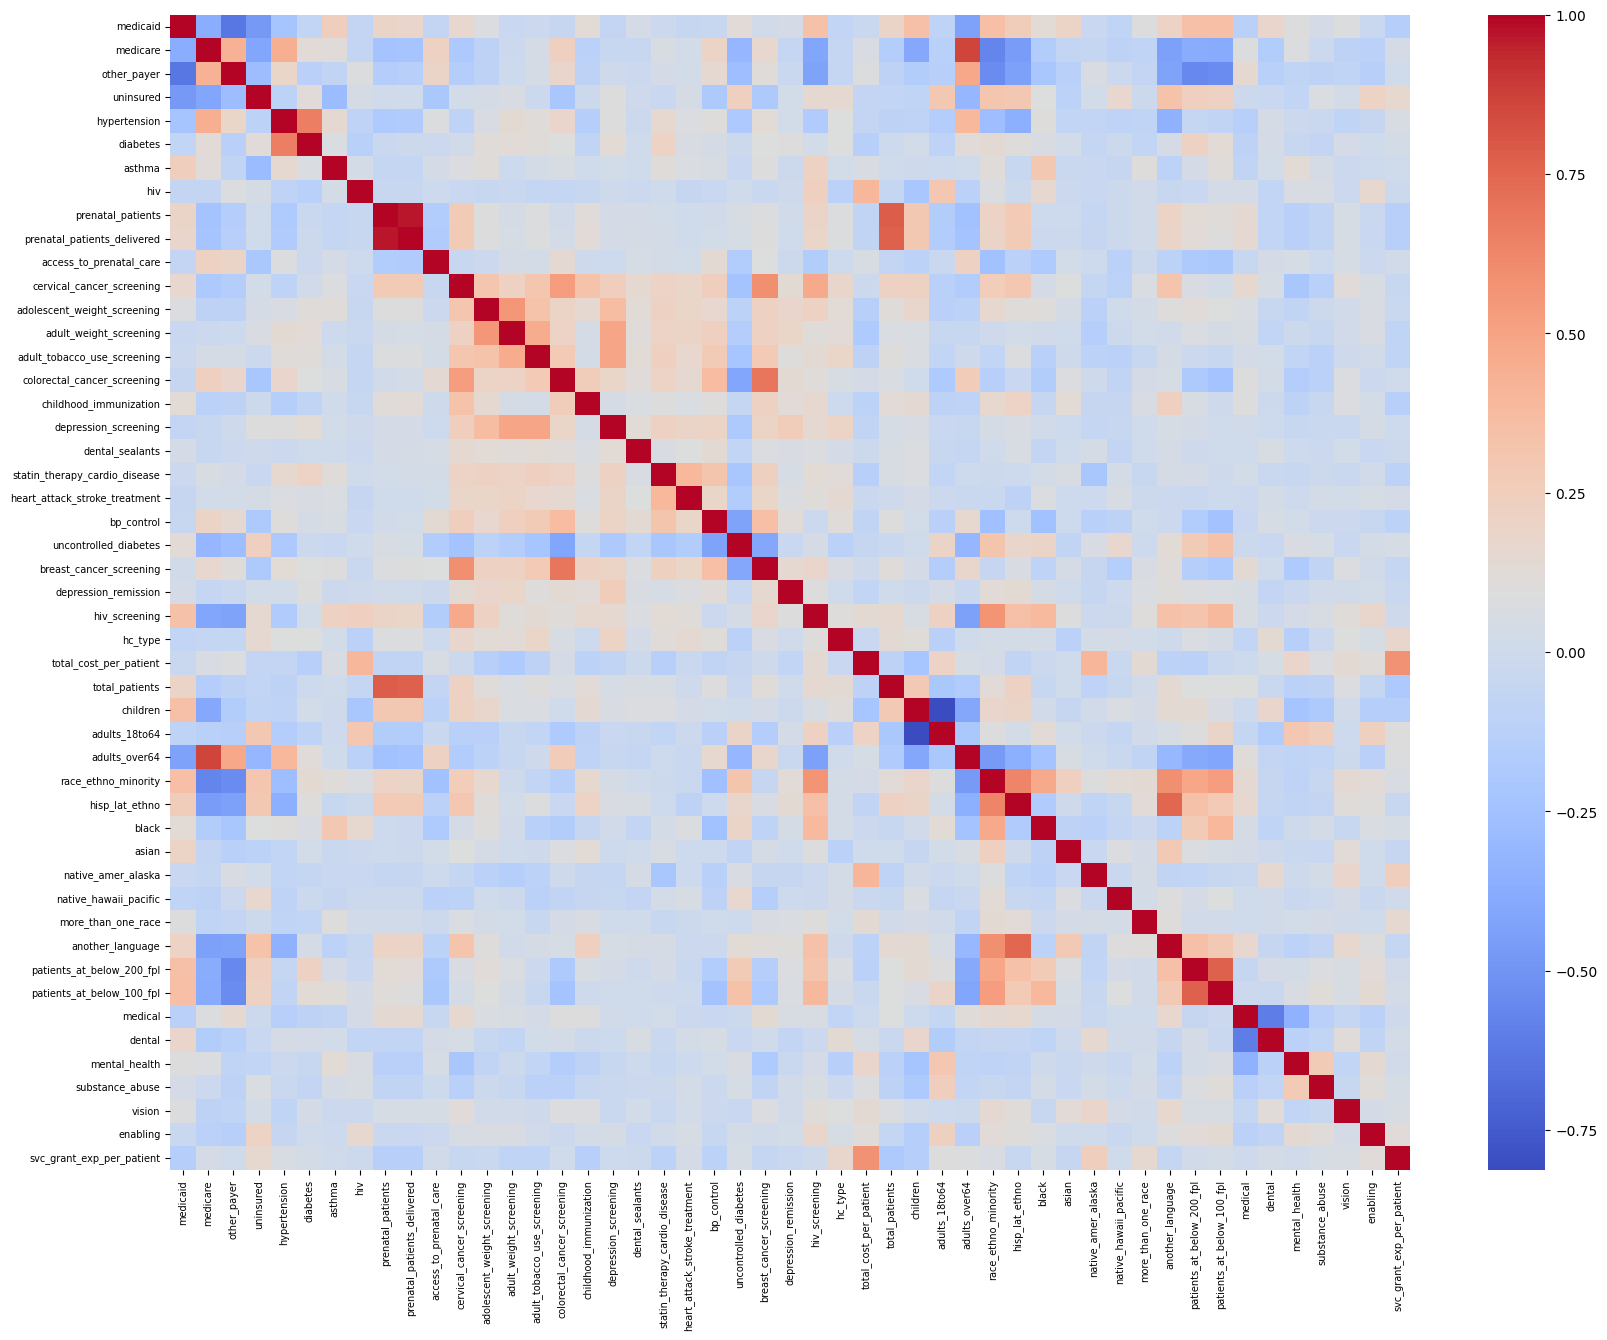

In [22]:
# Move target variables to beginning of correlation matrix dataframe, so they're easier to find in correlation heatmap
y_col = ['medicaid', 'medicare', 'other_payer', 'uninsured']
X_col = [col for col in df.columns if col not in y_col]
df = df[y_col + X_col]

# Create correlation matrix
corr_matrix = df.corr(numeric_only=True)

# Generate correlation heatmap
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

In [23]:
# View correlation coefficients
corr_matrix

,medicaid,medicare,other_payer,uninsured,hypertension,diabetes,asthma,hiv,prenatal_patients,prenatal_patients_delivered,access_to_prenatal_care,cervical_cancer_screening,adolescent_weight_screening,adult_weight_screening,adult_tobacco_use_screening,colorectal_cancer_screening,childhood_immunization,depression_screening,dental_sealants,statin_therapy_cardio_disease,heart_attack_stroke_treatment,bp_control,uncontrolled_diabetes,breast_cancer_screening,depression_remission,hiv_screening,hc_type,total_cost_per_patient,total_patients,children,adults_18to64,adults_over64,race_ethno_minority,hisp_lat_ethno,black,asian,native_amer_alaska,native_hawaii_pacific,more_than_one_race,another_language,patients_at_below_200_fpl,patients_at_below_100_fpl,medical,dental,mental_health,substance_abuse,vision,enabling,svc_grant_exp_per_patient
medicaid,1.000000,-0.370977,-0.630614,-0.477601,-0.229870,-0.070375,0.249542,-0.065546,0.199877,0.183889,-0.063182,0.168615,0.077677,-0.035664,-0.024449,-0.047938,0.129242,-0.065236,0.033909,-0.020573,-0.051617,-0.040846,0.124494,0.012873,0.030813,0.337513,-0.069067,-0.028821,0.195796,0.347654,-0.095045,-0.435435,0.350643,0.253813,0.136024,0.206359,-0.034122,-0.088608,0.096494,0.209662,0.344455,0.351882,-0.123449,0.185061,0.096110,0.033473,0.083810,-0.032576,-0.146675
medicare,-0.370977,1.000000,0.429353,-0.413614,0.444329,0.123595,0.120987,-0.066999,-0.238490,-0.227215,0.214895,-0.192580,-0.099402,-0.024089,0.041032,0.239881,-0.113918,-0.044490,-0.046074,0.051502,0.022501,0.202761,-0.315180,0.166202,-0.057407,-0.415328,-0.061092,0.062320,-0.153434,-0.395613,-0.126209,0.862338,-0.566158,-0.464881,-0.156801,-0.065296,-0.056576,-0.103880,-0.084411,-0.440925,-0.380401,-0.384612,0.082005,-0.158138,0.073141,-0.026059,-0.100652,-0.113977,0.032825
other_payer,-0.630614,0.429353,1.000000,-0.280439,0.186502,-0.122269,-0.081491,0.086373,-0.152767,-0.137196,0.197153,-0.148026,-0.101089,-0.007592,0.043905,0.182112,-0.098121,-0.000302,-0.020405,0.036060,0.016517,0.151111,-0.273983,0.110430,-0.033106,-0.424830,-0.059231,0.081905,-0.103709,-0.156149,-0.138592,0.479323,-0.540114,-0.443529,-0.210200,-0.127813,0.059209,-0.019790,-0.067541,-0.429681,-0.554178,-0.537626,0.152740,-0.130571,-0.088310,-0.101563,-0.089171,-0.134026,0.004409
uninsured,-0.477601,-0.413614,-0.280439,1.000000,-0.107036,0.115706,-0.288286,0.040150,0.006144,0.006724,-0.199829,0.017869,0.041529,0.061372,-0.025770,-0.209892,-0.015842,0.097841,-0.000171,-0.035758,0.037387,-0.186663,0.241354,-0.183418,0.020563,0.154200,0.155543,-0.063627,-0.072570,-0.088511,0.292968,-0.309828,0.311888,0.298663,0.090691,-0.107971,0.021405,0.171515,-0.018025,0.328231,0.236197,0.219099,-0.016255,-0.036167,-0.072733,0.072108,0.023253,0.210301,0.158343
hypertension,-0.229870,0.444329,0.186502,-0.107036,1.000000,0.655223,0.156974,-0.091545,-0.180004,-0.168249,0.083310,-0.091484,0.063372,0.139533,0.108814,0.180499,-0.139928,0.098889,-0.023416,0.163737,0.078259,0.101754,-0.192102,0.132046,0.020718,-0.171761,0.087754,-0.063978,-0.101278,-0.095614,-0.150049,0.395532,-0.268377,-0.358374,0.103508,-0.074733,-0.071931,-0.095139,-0.086436,-0.339868,-0.056650,-0.081179,-0.133347,0.039686,-0.022406,-0.031306,-0.085247,-0.054618,0.056754
diabetes,-0.070375,0.123595,-0.122269,0.115706,0.655223,1.000000,0.069783,-0.128981,-0.027266,-0.018454,-0.025488,0.014931,0.112215,0.129111,0.108469,0.086811,-0.076913,0.135050,0.002514,0.207424,0.058886,0.038916,-0.014374,0.089801,0.095078,0.018608,0.092504,-0.135634,-0.009885,0.018904,-0.096393,0.119111,0.140981,0.106408,0.062635,0.017992,-0.061738,-0.016693,-0.070974,0.037736,0.222043,0.130662,-0.102952,0.033305,-0.044585,-0.068374,0.030540,0.008824,0.028906
asthma,0.249542,0.120987,-0.081491,-0.288286,0.156974,0.069783,1.000000,0.029749,-0.058357,-0.061092,0.031280,0.079185,0.108248,-0.010547,0.030003,0.053760,0.006470,0.021866,0.006657,0.111677,0.071179,0.056421,-0.036243,0.098197,-0.014031,0.223321,0.020630,0.062346,0.007887,0.000960,-0.006325,0.008286

Using the heatmap and correlation matrix above, I've decided to remove several columns:
- 'adults_18to74' (strong correlation with 'children')
- 'prenatal_patients_delivered' (strong correlation with 'prenatal_patients'
- 'patients_at_below_100_fpl' (strong correlation with 'patients_at_below_100_fpl')

When deciding between highly correlated variables, I've kept the variable with the stronger correlation with the targets.

In [24]:
# Drop columns to avoid multicollinearity
df = df.drop(['adults_18to64',
              'prenatal_patients_delivered',
              'patients_at_below_100_fpl'],
             axis=1)

### Categorical Variables

The 'state' column is a categorical variable represented by string values. Because a health center's payer mix is significantly influenced by the state in which it operates (largely due to medicaid programs and other state-specific policies), I've decided to keep this variable and use one-hot encoding to convert it to numeric values.

In [25]:
# Use one-hot encoding to convert 'state' column to binary numeric values
df = pd.get_dummies(df, columns=['state'], drop_first=True)

## Model Building

Because the UDS report includes four payer types, and each is likely impacted differently by the available features, I will create a distinct linear regression model for each payer:

- Medicaid
- Medicare
- Other Payer
- Uninsured

To prepare the data for model training and testing, I'll split the data into train and test datasets.

In [26]:
# Separate the features from the targets
X = df.drop(columns=['medicaid', 'medicare', 'other_payer', 'uninsured'])
y = df[['medicaid', 'medicare', 'other_payer', 'uninsured']]

# Split dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Baseline Models

First, to establish a baseline, I'll run linear regression models for each of the four payers using all columns in X as features.

In [27]:
# Create dataframe to store model evaluation metrics
base_results_df = pd.DataFrame(columns = ['Measures']+list(y.columns))
base_results_df['Measures'] = ['MSE', 'R^2']

# Iterate through payer types, creating a distinct linear regression model for each
for payer in y.columns:

    # Fit the model
    model = LinearRegression()
    model.fit(X_train, y_train[payer])

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test[payer], y_pred)
    r2 = r2_score(y_test[payer], y_pred)

    # Add results to base_results_df
    base_results_df[payer] = [mse, r2]

base_results_df = base_results_df.set_index('Measures')
base_results_df

,medicaid,medicare,other_payer,uninsured
Measures,,,,
MSE,0.009320,0.000877,0.006184,0.010184
R^2,0.715715,0.853947,0.588071,0.603910


### Tuned Models

The above baseline model uses all available columns as features. I'll now use a lasso regression to help select features that are most relevant to payer mix prediction, and penalize features that are less relevant. This will generate a more finely tuned linear regression model that should improve accuracy.

In [28]:
# Create dataframe to store model evaluation metrics
lasso_results_df = pd.DataFrame(columns = ['Measures']+list(y.columns))
lasso_results_df['Measures'] = ['MSE', 'R^2']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Iterate through payer types, creating a distinct lasso regression model for each
for payer in y.columns:

    # Fit the model
    lasso = Lasso()
    param_grid = {'alpha': np.logspace(-5, 1, 50)}
    lasso_cv = GridSearchCV(lasso, param_grid, cv=5, n_jobs=-1)
    lasso_cv.fit(X_train_scaled, y_train[payer])

    # Predict and evaluate
    y_pred = lasso_cv.predict(X_test_scaled)
    mse = mean_squared_error(y_test[payer], y_pred)
    r2 = r2_score(y_test[payer], y_pred)

    # Add results to base_results_df
    lasso_results_df[payer] = [mse, r2]

lasso_results_df = lasso_results_df.set_index('Measures')
lasso_results_df

,medicaid,medicare,other_payer,uninsured
Measures,,,,
MSE,0.008819,0.000832,0.006210,0.009768
R^2,0.731021,0.861400,0.586298,0.620110


### Model Evaluation

Now that I have the results from my models before and after tuning, I'll generate bar charts to visualize the results and compare.

<Figure size 800x500 with 0 Axes>

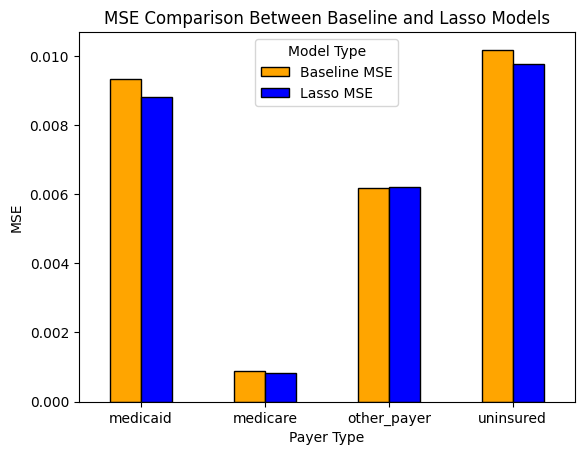

<Figure size 800x500 with 0 Axes>

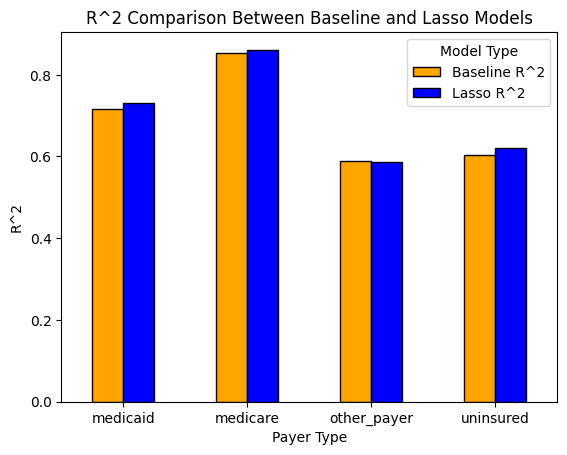

In [31]:
# Combine MSE scores into one dataframe
mse_df = pd.DataFrame({
    'Baseline MSE': base_results_df.loc['MSE'],
    'Lasso MSE': lasso_results_df.loc['MSE']
    })

# Create bar plot
plt.figure(figsize=(8, 5))
mse_df.plot(kind='bar', color=['orange', 'blue'], edgecolor='black')
plt.title('MSE Comparison Between Baseline and Lasso Models')
plt.ylabel('MSE')
plt.xlabel('Payer Type')
plt.xticks(rotation=0)
plt.legend(title='Model Type')
plt.show()

# Combine R^2 scores into one dataframe
r2_df = pd.DataFrame({
    'Baseline R^2': base_results_df.loc['R^2'],
    'Lasso R^2': lasso_results_df.loc['R^2']
    })

# Create bar plot
plt.figure(figsize=(8, 5))
r2_df.plot(kind='bar', color=['orange', 'blue'], edgecolor='black')
plt.title('R^2 Comparison Between Baseline and Lasso Models')
plt.ylabel('R^2')
plt.xlabel('Payer Type')
plt.xticks(rotation=0)
plt.legend(title='Model Type')
plt.show()

## Conclusion

The performance metrics of these models show that the lasso technique slightly improved the medicaid, medicare, and uninsured payer type models, although no significant change was seen in the other_payer models.

The **medicare** model was the highest performing model, with an R^2 score of 0.86. This is likely due to the fact that medicare's eligibility is dependent on age. Therefore, a health center with an older patient population and higher rates of health conditions associated with older individuals will usually have a higher percentage of medicare patients than other health centers. This allows the model to fairly accurately predict the medicare payer mix percentage.

While not quite as accurate as the medicare model, the **medicaid** model also performed well with an R^2 score of 0.73. The other two payer types, **other_payer** and **uninsured**, did not perform as well, with R^2 scores of 0.59	and 0.62, respectively. Because other_payer and uninsured percentages are likely impacted by socioeconomic factors, this model could be improved by including additional data relating to these external variables. While the UDS dataset does include variables relating to socioeconomics, it likely does not provide enough detail for the linear regression model to effectively interpret the impact of these types of variables on payer mix. By bringing in additional data from another source, the model could be improved.